# Example scVI run on a PBMC dataset

2024.11.04

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import yaml

%matplotlib inline

In [2]:
# optional (total!) cleanup of old runs

# !rm -r lightning_logs/

Run scVI using Cellarium ML and explore the outputs.

In [3]:
# your config file for running scVI

train_config_file = "../examples/cli_workflow/scvi_pbmc_train_config.yaml"
predict_config_file = "../examples/cli_workflow/scvi_pbmc_predict_config.yaml"

In [4]:
!cat {train_config_file}

# lightning.pytorch==2.2.1
seed_everything: true
trainer:
  accelerator: cpu
  strategy: auto
    # class_path: lightning.pytorch.strategies.DDPStrategy
    # dict_kwargs:
    #   broadcast_buffers: false
    #   find_unused_parameters: true
  devices: auto
  num_nodes: 1
  precision: 32
  logger: null
  callbacks: 
  - class_path: lightning.pytorch.callbacks.LearningRateMonitor
    init_args:
      logging_interval: step
      log_momentum: false
  # - class_path: lightning.pytorch.callbacks.EarlyStopping
  #   init_args:
  #     monitor: train_loss
  #     min_delta: 0.0
  #     patience: 45
  #     mode: min
  fast_dev_run: false
  max_epochs: 50
  min_epochs: null
  max_steps: -1
  min_steps: null
  max_time: null
  limit_train_batches: null
  limit_val_batches: null
  limit_test_batches: null
  limit_predict_batches: null
  overfit_batches: 0.0
  val_check_interval: null
  check_val_every_n_epoch: 1
  num_sanity_val_steps: null
  log_every_n_steps: 1
  enable_checkpointing: true
 

In [5]:
!cat {predict_config_file}

# lightning.pytorch==2.2.1
seed_everything: true
trainer:
  accelerator: cpu
  strategy: auto
    # class_path: lightning.pytorch.strategies.DDPStrategy
    # dict_kwargs:
    #   broadcast_buffers: false
    #   find_unused_parameters: true
  devices: auto
  num_nodes: 1
  precision: 32
  logger: null
  callbacks: 
  - class_path: cellarium.ml.callbacks.PredictionWriter
    init_args:
      output_dir: /Users/sfleming/Documents/Github/cellarium-ml/notebooks/lightning_logs/version_0/predictions
      prediction_size: null
  fast_dev_run: false
  max_epochs: 50
  min_epochs: null
  max_steps: -1
  min_steps: null
  max_time: null
  limit_train_batches: null
  limit_val_batches: null
  limit_test_batches: null
  limit_predict_batches: null
  overfit_batches: 0.0
  val_check_interval: null
  check_val_every_n_epoch: 1
  num_sanity_val_steps: null
  log_every_n_steps: 1
  enable_checkpointing: true
  enable_progress_bar: true
  enable_model_summary: null
  accumulate_grad_batches: 1
  grad

## Run scVI

In [6]:
!cellarium-ml scvi fit --config {train_config_file}

/Users/sfleming/miniconda3/envs/cellarium/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py:42: No seed found, seed set to 0
Seed set to 0
SingleCellVariationalInference(
  (z_encoder): EncoderSCVI(
    (fully_connected): FullyConnectedWithBatchArchitecture(
      (module_list): ModuleList(
        (0): DressedLayer(
          (layer): LinearWithBatch(
            in_features=4000, out_features=128, bias=True
            (bias_decoder): FullyConnectedLinear(
              (module_list): ModuleList(
                (0): Linear(in_features=12, out_features=128, bias=False)
              )
            )
          )
          (dressing): Sequential(
            (0): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_feature

### Make predictions (i.e. embed dataset into latent space)

Make sure that the "ckpt_path" in the predict YAML config file points to the output of the run from the last cell!

In [7]:
!cellarium-ml scvi predict --config {predict_config_file}

/Users/sfleming/miniconda3/envs/cellarium/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py:42: No seed found, seed set to 0
Seed set to 0
SingleCellVariationalInference(
  (z_encoder): EncoderSCVI(
    (fully_connected): FullyConnectedWithBatchArchitecture(
      (module_list): ModuleList(
        (0): DressedLayer(
          (layer): LinearWithBatch(
            in_features=4000, out_features=128, bias=True
            (bias_decoder): FullyConnectedLinear(
              (module_list): ModuleList(
                (0): Linear(in_features=12, out_features=128, bias=False)
              )
            )
          )
          (dressing): Sequential(
            (0): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_feature

## Load dataset and scVI latents

NOTE: Do not attempt this if the dataset itself is too large to fit in memory.

### Raw dataset

In [8]:
# get the location of the dataset
with open(train_config_file, "r") as file:
    config_dict = yaml.safe_load(file)
data_path = config_dict["data"]["dadc"]["init_args"]["filenames"]
print(f"Data is coming from {data_path}")

# get a dataset object
adata = sc.read_h5ad(data_path)
adata

Data is coming from /Users/sfleming/Desktop/pbmc_count.h5ad


AnnData object with n_obs × n_vars = 31774 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition', 'concat'

### scVI latent representation

This is getting pulled from the output of the `cellarium-ml scvi predict` run.

In [9]:
# get the location of the prediction output

with open(predict_config_file, "r") as file:
    config_dict = yaml.safe_load(file)
prediction_path = None
for callback in config_dict["trainer"]["callbacks"]:
    if "PredictionWriter" in callback["class_path"]:
        prediction_path = callback["init_args"]["output_dir"]
if prediction_path is None:
    raise ValueError("PredictionWriter callback not found in the predict config file")
print(f"Latents are coming from {prediction_path}/")

Latents are coming from /Users/sfleming/Documents/Github/cellarium-ml/notebooks/lightning_logs/version_0/predictions/


In [10]:
# load the scvi latent representation and put it into adata.obsm["X_scvi"]

dfs = []

for file in glob.glob(os.path.join(prediction_path, "batch*.csv")):
    dfs.append(pd.read_csv(file, index_col=0, header=None))

latent_df = pd.concat(dfs, axis=0)
latent_df = latent_df.loc[adata.obs_names]
adata.obsm["X_scvi"] = latent_df.values
adata

AnnData object with n_obs × n_vars = 31774 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition', 'concat'
    obsm: 'X_scvi'

In [11]:
adata.obsm["X_scvi"].shape

(31774, 10)

In [12]:
adata.obsm["X_scvi"]

array([[ 0.05458012, -0.07915613, -0.67039025, ..., -0.9037418 ,
         0.4871668 , -0.03495325],
       [-0.22429293,  0.9674162 ,  0.57966584, ...,  0.8510373 ,
         0.53750116,  2.2472813 ],
       [-0.7961291 ,  1.4055728 ,  0.49594083, ...,  0.79653746,
        -0.28752595,  2.217181  ],
       ...,
       [ 3.7736983 , -1.3370699 ,  0.86039823, ...,  1.5859486 ,
         0.26454467,  1.3939664 ],
       [ 0.9194591 , -1.7224334 ,  0.62958527, ...,  1.1643666 ,
         0.52073944,  1.4807333 ],
       [ 1.9979447 , -0.79500335,  0.22741207, ...,  1.7299955 ,
         0.13661098,  1.2801594 ]])

# Visualizations

In [13]:
sc.set_figure_params(fontsize=14, vector_friendly=True)

## Before scVI

In [14]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=20, n_neighbors=15, metric="euclidean", method="umap")
sc.tl.umap(adata)
adata.obsm["X_raw_umap"] = adata.obsm["X_umap"].copy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/sfleming/miniconda3/envs/cellarium/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


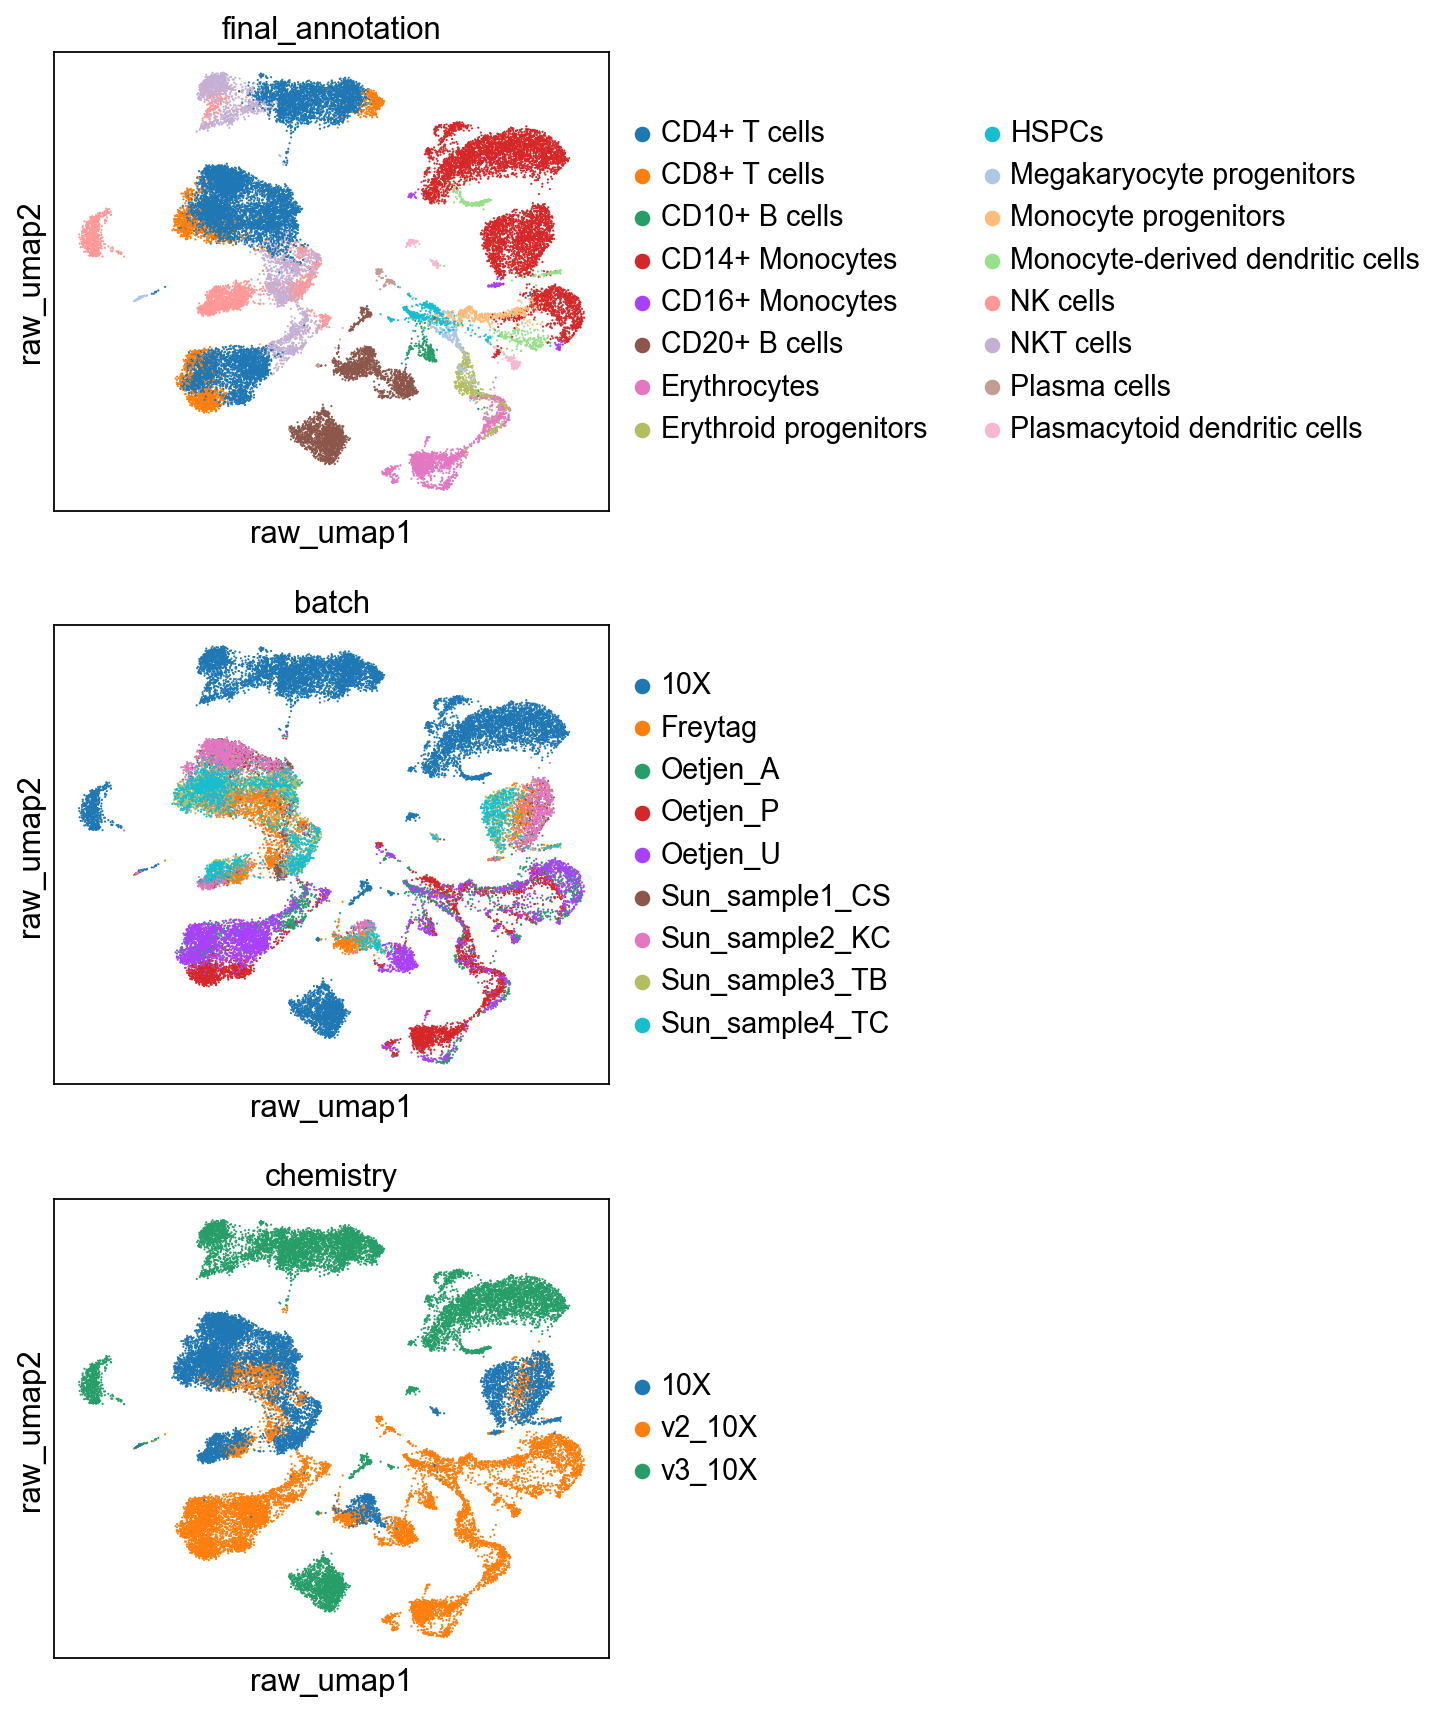

In [15]:
sc.pl.embedding(adata, basis="raw_umap", color=["final_annotation", "batch", "chemistry"], ncols=1)

## After scVI

In [16]:
sc.pp.neighbors(adata, use_rep="X_scvi", n_neighbors=15, metric="euclidean", method="umap")
sc.tl.umap(adata)
adata.obsm["X_scvi_umap"] = adata.obsm["X_umap"].copy()

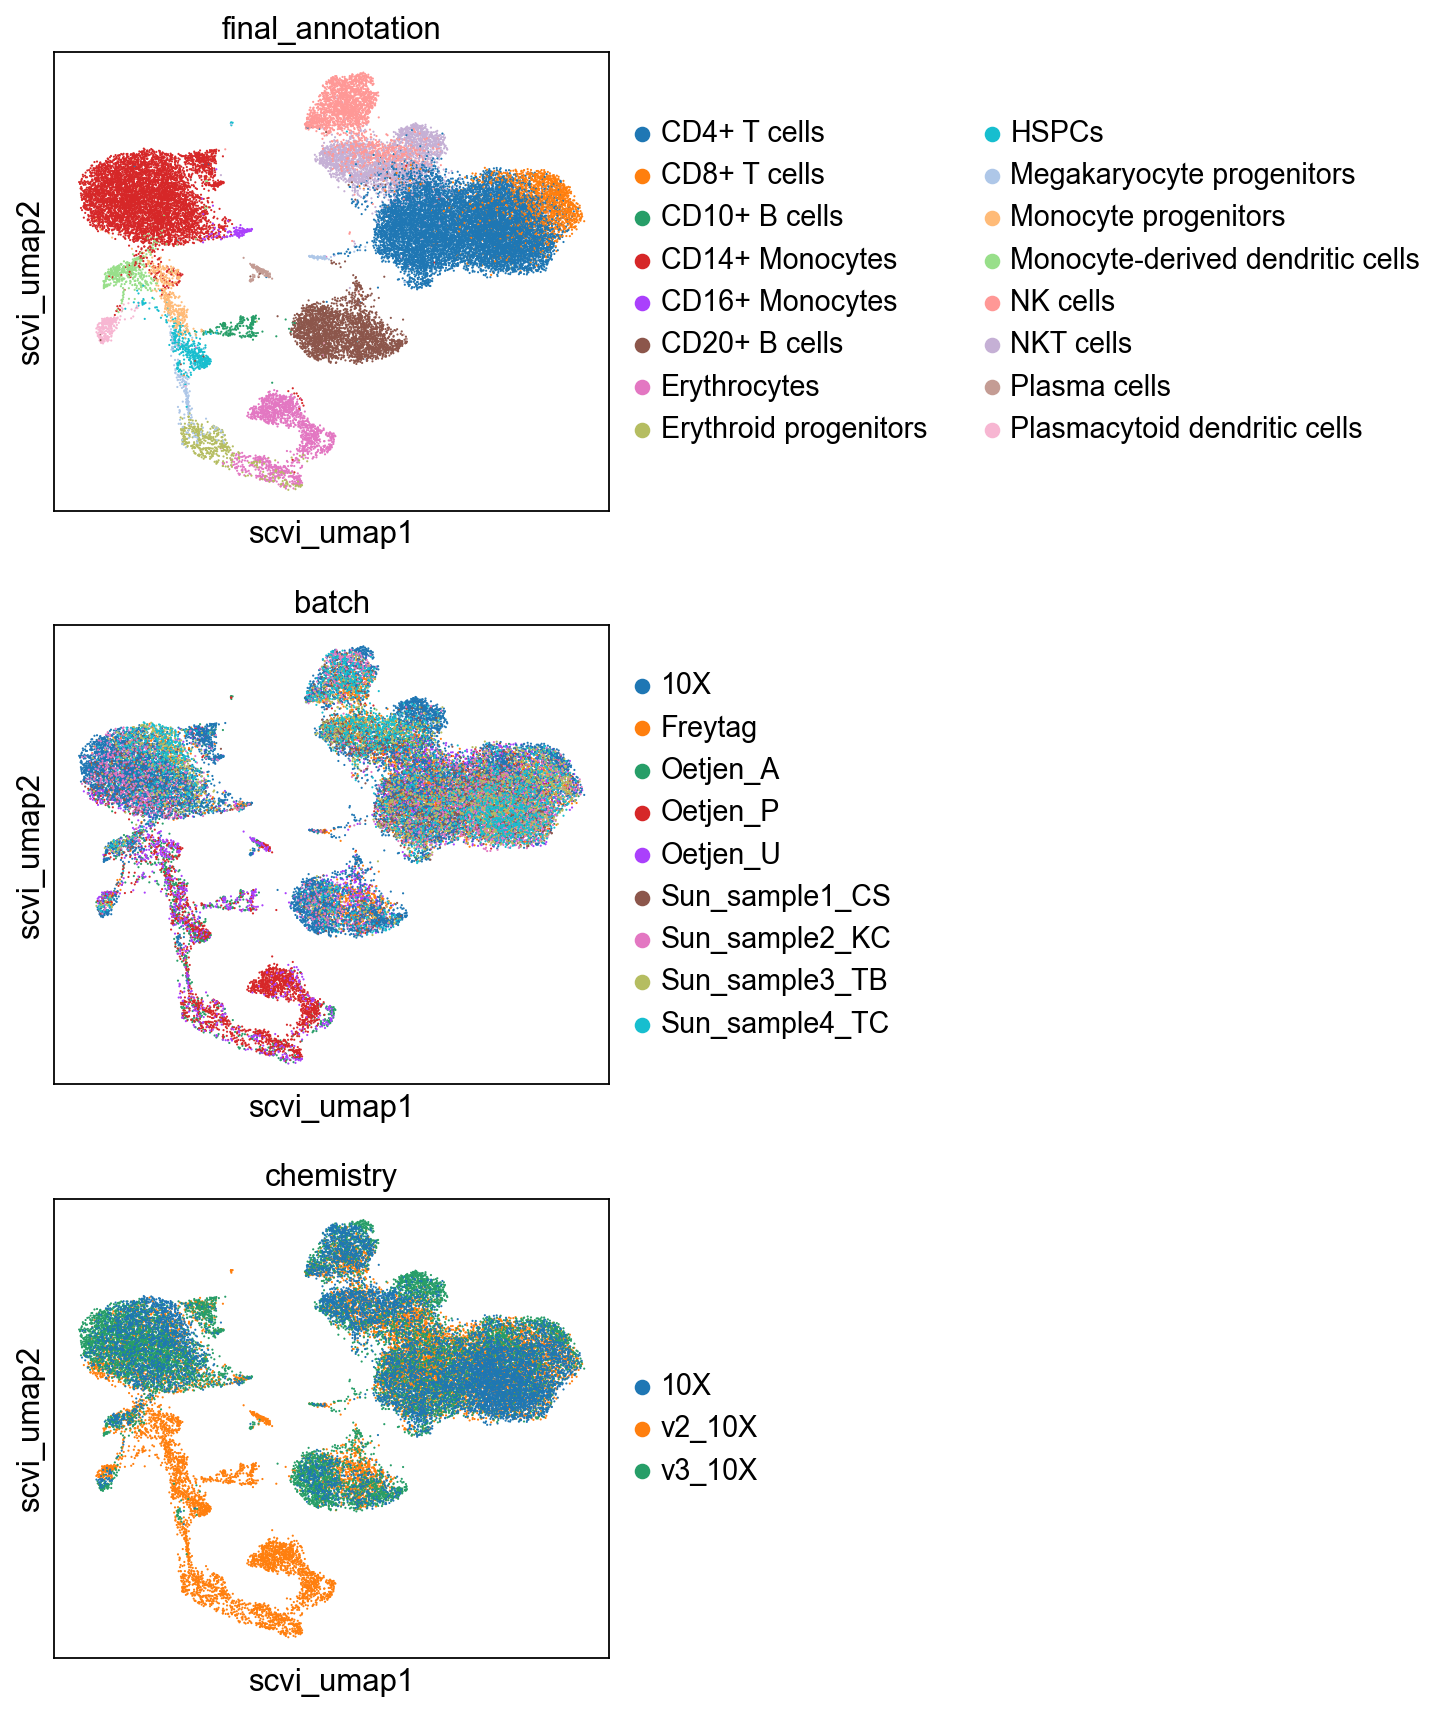

In [17]:
sc.pl.embedding(adata, basis="scvi_umap", color=["final_annotation", "batch", "chemistry"], ncols=1)

## Batch embeddings

In [18]:
# get the location of the checkpointed model
with open(predict_config_file, "r") as file:
    config_dict = yaml.safe_load(file)
checkpoint_file = config_dict["ckpt_path"]
checkpoint_file

'/Users/sfleming/Documents/Github/cellarium-ml/notebooks/lightning_logs/version_0/checkpoints/epoch=49-step=3150.ckpt'

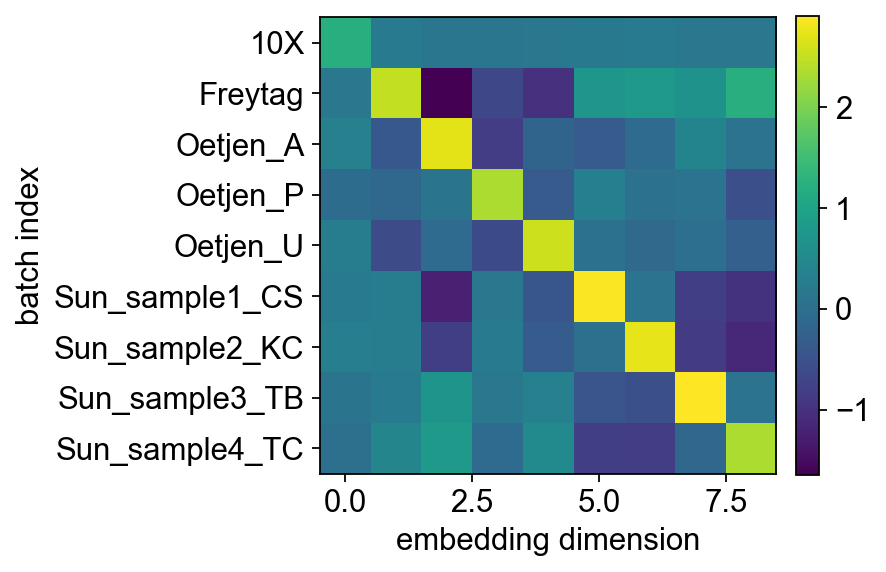

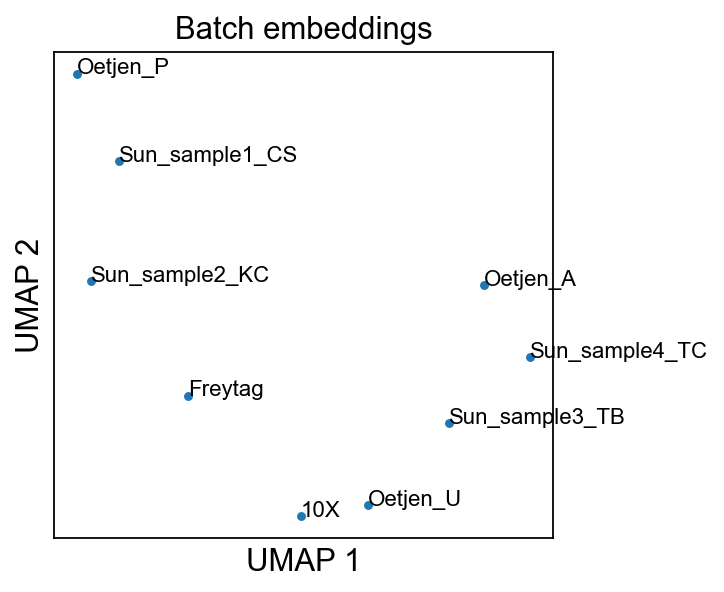

In [19]:
if config_dict["model"]["model"]["init_args"]["batch_embedded"]:
    import umap

    from cellarium.ml.core import CellariumModule
    from cellarium.ml.models.scvi import batch_index_to_batch_label

    scvi_model = CellariumModule.load_from_checkpoint(checkpoint_file).model

    # show batch embeddings as an image
    batch_key = config_dict["data"]["batch_keys"]["batch_index_n"]["key"]
    if isinstance(batch_key, str):
        batch_key = [batch_key]
    batch_lookup_df = batch_index_to_batch_label(adata, batch_key)
    keep_inds = []
    used_combos = set(adata.obs[batch_key].apply(tuple, axis=1).values)
    for i in range(len(batch_lookup_df)):
        if tuple(batch_lookup_df.iloc[i][batch_key]) in used_combos:
            keep_inds.append(i)
    batch_lookup_df = batch_lookup_df.iloc[keep_inds]
    batch_rep_mean_bd = scvi_model.batch_representation_mean_bd.detach().cpu().numpy()
    batch_rep_mean_bd = batch_rep_mean_bd[keep_inds]
    order = np.argsort(batch_lookup_df["scvi_batch_code"])
    if len(batch_key) > 1:
        batch_names = batch_lookup_df[batch_key].apply(tuple, axis=1).values[order]
    else:
        batch_names = batch_lookup_df[batch_key[0]].values[order]
    plt.imshow(batch_rep_mean_bd)
    plt.xlabel("embedding dimension")
    plt.yticks(ticks=range(len(batch_names)), labels=batch_names)
    plt.ylabel("batch index")
    plt.grid(False)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    # show batch embeddings as a umap
    um = umap.UMAP(n_neighbors=3, metric="cosine").fit_transform(batch_rep_mean_bd)
    plt.plot(um[:, 0], um[:, 1], ".")
    for x, y, s in zip(um[:, 0], um[:, 1], batch_names):
        plt.annotate(str(s), (x, y), fontsize=10)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title("Batch embeddings")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

else:
    print(
        "Model was run with `batch_embedded: false` in the config under "
        "model.model.init_args, so we did not learn an embedding of batch."
    )

In [20]:
pd.crosstab(adata.obs["batch"], adata.obs["chemistry"])

chemistry,10X,v2_10X,v3_10X
batch,,,
10X,0,0,10393
Freytag,0,3347,0
Oetjen_A,0,2535,0
Oetjen_P,0,3243,0
Oetjen_U,0,3668,0
Sun_sample1_CS,1704,0,0
Sun_sample2_KC,2175,0,0
Sun_sample3_TB,2322,0,0
Sun_sample4_TC,2387,0,0
